# Train tabular model/ text model/ new tabular+text model

From https://nbviewer.jupyter.org/gist/joshfp/b62b76eae95e6863cb511997b5a63118/5.full-deep-learning.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from sklearn.model_selection import KFold

In [4]:
from fastai.callbacks.tracker import *
from fastai.text import *
from fastai.tabular import *

In [5]:
def reset_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
reset_seed()

In [6]:
mercari_path = Path('data/')

In [7]:
from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.7.1
fastai        : 1.0.54
fastprogress  : 0.1.21
torch         : 1.1.0.dev20190418
nvidia driver : 410.104
torch cuda    : 9.0.176 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 8116MB | GeForce GTX 1080

=== Environment === 
platform      : Linux-4.15.0-52-generic-x86_64-with-debian-stretch-sid
distro        : #56~16.04.1-Ubuntu SMP Thu Jun 6 12:03:31 UTC 2019
conda env     : python37
python        : /home/quantran/anaconda3/envs/python37/bin/python
sys.path      : 
/home/quantran/kwon/kaggle/mercari
/home/quantran/anaconda3/envs/python37/lib/python37.zip
/home/quantran/anaconda3/envs/python37/lib/python3.7
/home/quantran/anaconda3/envs/python37/lib/python3.7/lib-dynload
/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages
/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/IPython/extensions
/home/quantran/.ipython
```

Please make sure 

# Prepare data

In [8]:
def preprocess_text_cols(df: pd.DataFrame) -> pd.DataFrame:
  
    df['category_name'] = df['category_name'].fillna('//')
    df['category1'] = df['category_name'].apply(lambda x : x.split('/')[0].strip())
    df.loc[df.category1=='','category1']= np.NaN
    df['category2'] = df['category_name'].apply(lambda x : x.split('/')[1].strip())
    df.loc[df.category2=='','category2']= np.NaN
    df['category3'] = df['category_name'].apply(lambda x : x.split('/')[2].strip())
    df.loc[df.category3=='','category3']= np.NaN
    df['category_name'] = df['category_name'].apply( lambda x : ' '.join( x.split('/') ).strip() )
    df.loc[df.category_name=='','category_name']= 'No category' # let this info in when concatenating text for RNN
    
    df_bn_fillna = df['brand_name'].fillna('No brand')
    df['text'] = (df['name'].fillna('No name') + '. ' + df_bn_fillna + '. ' + 
                  df['category_name'] + '. ' + df['item_description'].fillna('No description'))
    return df[['category1','category2','category3','brand_name', 'text', 'shipping', 'item_condition_id','price']]

def preprocess_all(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price
    
    test = pd.read_table(mercari_path/'test_stg2.tsv').drop('test_id',axis=1)
    test['price'] = np.NAN
    train = train[train['price'] > 0].reset_index(drop=True)
    all_df = pd.concat([train,test],axis=0).reset_index(drop=True)
    del train
    del test
    gc.collect()

    all_df = preprocess_text_cols(all_df)
    train_df = all_df[~all_df.price.isnull()]
    test_df = all_df[all_df.price.isnull()]
    del all_df
    gc.collect()
    
    if sample:
        np.random.seed(42)
        sample = np.random.permutation(sample)
        train_df = train_df.loc[sample].reset_index(drop=True)
        
    test_df= test_df.drop('price',axis=1)    
    return train_df,test_df

def preprocess_train(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price

    if sample:
        np.random.seed(42)
        sample = np.random.permutation(sample)
        train = train.loc[sample].reset_index(drop=True)

    train = preprocess_text_cols(train)

    return train
def get_val_idxs(train,n_splits=20):
    np.random.seed(42)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_idxs, valid_idxs = next(cv.split(train))
    return train_idxs,valid_idxs

In [9]:
n=1482535 # train shape

In [10]:
gc.collect()

0

In [11]:
train_df,test_df = preprocess_all(int(0.02*n)) # only use 2% for testing

train_df.shape,test_df.shape

((29650, 8), (3460725, 7))

In [12]:
# train_df = preprocess_train()
# train_df.shape

In [13]:
train_df.columns

Index(['category1', 'category2', 'category3', 'brand_name', 'text', 'shipping',
       'item_condition_id', 'price'],
      dtype='object')

In [14]:
train_df.price = np.log1p(train_df['price']) # Metric for this is RMSLE, we log them so we can use MSE in NN

In [15]:
train_df.head()

,category1,category2,category3,brand_name,text,shipping,item_condition_id,price
0,Beauty,Makeup,Face,NaN,Primer & Brush Duo. No brand. Beauty Makeup Fa...,0,2,2.833213
1,Women,Dresses,"Above Knee, Mini",Bebe,Bebe black feather dress. Bebe. Women Dresses ...,0,2,3.555348
2,Women,Athletic Apparel,Jackets,NaN,For Kayla-do not buy. No brand. Women Athletic...,1,1,3.258097
3,Vintage & Collectibles,Accessories,Keychain,NaN,Rhinestone choker & pom pom keychain. No brand...,1,1,2.397895
4,Beauty,Makeup,Eyes,NaN,FREE SHP GREEN CONTAC LENSES. No brand. Beauty...,1,1,2.302585


In [16]:
for i in range(4):
    print(train_df.text[i])
    print('-'*20)

Primer & Brush Duo. No brand. Beauty Makeup Face. Younique face and eye primer : used once Brush: never used
--------------------
Bebe black feather dress. Bebe. Women Dresses Above Knee, Mini. Bebe black feather dress strapless around the neck decorative front bejeweled bow tie in the back satin beautiful dress like new no flaws size extra small women's
--------------------
For Kayla-do not buy. No brand. Women Athletic Apparel Jackets. New with tags and long sleeve. No free shipping and firm on price. Also have available in a size medium. No free shipping and firm on price.
--------------------
Rhinestone choker & pom pom keychain. No brand. Vintage & Collectibles Accessories Keychain. 1x rhinestone choker ( handmade) 1x pink pom pom keychain Brand new I ship fast
--------------------


In [17]:
cat_names=['category1','category2','category3','brand_name','shipping']
cont_names= list(set(train_df.columns) - set(cat_names) - {'price','text'})
print(f'# of continuous feas: {len(cont_names)}')
print(f'# of categorical feas: {len(cat_names)}')
dep_var = 'price'
procs = [FillMissing,Categorify, Normalize]

txt_cols=['text']

len(cat_names) + len(cont_names) + 2 == train_df.shape[1]

# of continuous feas: 1
# of categorical feas: 5


True

Prepare validation indices using kfold

In [18]:
train_idxs,val_idxs = get_val_idxs(train_df,n_splits=20)
# train_idxs,val_idxs = get_val_idxs(train_df,n_splits=5)
train_idxs,val_idxs
train_idxs.shape,val_idxs.shape

(array([    0,     1,     2,     3, ..., 29646, 29647, 29648, 29649]),
 array([    6,    34,    92,    96, ..., 29586, 29597, 29634, 29642]))

((28167,), (1483,))

# Get databunches and learners

In [19]:
def get_tabular_databunch(train_df,bs=100,val_idxs=val_idxs,path = mercari_path):
    return (TabularList.from_df(train_df, cat_names, cont_names, procs=procs, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols=dep_var,label_cls=FloatList)
#                             .add_test(TabularTextList.from_df(test_df, cat_names, cont_names, txt_cols,path=path))
                            .databunch(bs=bs))

In [20]:
def get_text_databunch(train_df,bs=100,val_idxs=val_idxs,path = mercari_path):
    data_lm = load_data(path, 'data_lm.pkl', bs=bs)
    return (TextList.from_df(train_df, cols = txt_cols[0], vocab=data_lm.vocab, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols=dep_var,label_cls=FloatList)
                            .databunch(bs=bs))

In [21]:
def get_tabular_learner(data,params,seed=42):
    return tabular_learner(data,metrics=[root_mean_squared_error],**params)

def get_text_learner(data,params,seed=42):

    learn = text_classifier_learner(data,AWD_LSTM,metrics=root_mean_squared_error,**params)
    
    # language model trained in 'mercari language model' notebook
    
    #TODO: new AWD_LSTM structure causing mismatch. Retrain language model!
#     encoder_name = 'bs60-awdlstm-enc-stage2'
#     learn.load_encoder(encoder_name) 
    return learn

In [22]:
from fastai_tabtext2 import *

In [23]:
def get_databunches(bs=64,path= mercari_path):
    # get tabtext databunch, tabular databunch (for tabular model) and text databunch (for text model)
    tab_db = get_tabular_databunch(train_df[cat_names + cont_names+ [dep_var]])
    text_db = get_text_databunch(train_df[txt_cols +[dep_var]])
    
    train_ds = ConcatDataset(tab_db.train_ds.x, text_db.train_ds.x, tab_db.train_ds.y)
    valid_ds = ConcatDataset(tab_db.valid_ds.x, text_db.valid_ds.x, tab_db.valid_ds.y)
    
    train_sampler = SortishSampler(text_db.train_ds.x, key=lambda t: len(text_db.train_ds[t][0].data), bs=bs//2)
    valid_sampler = SortSampler(text_db.valid_ds.x, key=lambda t: len(text_db.valid_ds[t][0].data))

#     train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler)
    train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler,shuffle=True)
    valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
    data = DataBunch(train_dl, valid_dl, device=defaults.device, collate_fn=tabtext_collate, path=path)
    return data,tab_db,text_db

In [24]:
data,tab_db,text_db = get_databunches(bs=64)

In [25]:
tab_params={
    'layers':[500],
    'emb_drop': 0.,
    'y_range': [0,6],
    'use_bn': True,    
    }

text_params={
    #     'lin_ftrs':[1000],
    #     'ps': [0.001,0,0],
        'bptt':70,
        'max_len':20*70,
        'drop_mult': 1., 
    #     'use_bn': True,    
    }

In [26]:
tab_learner = get_tabular_learner(tab_db,tab_params)
text_learner = get_text_learner(text_db,text_params)  

In [27]:
text_learner.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(33781, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(33781, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.4)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=

# Get tabular_text learner and model

In [28]:
lin_layers=[500]
ps=[0.]

In [29]:
# 50 is the default lin_ftrs in AWD_LSTM
lin_layers[-1]+= 50 if 'lin_ftrs' not in text_params else text_params['lin_ftrs']
    

In [30]:
# be careful here. If no lin_ftrs is specified, the default lin_ftrs is 50

learner = get_tabtext_learner(data,tab_learner,text_learner,lin_layers ,ps)

In [31]:
learner.model

ConcatModel(
  (mod_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(11, 6)
      (1): Embedding(110, 22)
      (2): Embedding(590, 57)
      (3): Embedding(1201, 85)
      (4): Embedding(3, 3)
    )
    (emb_drop): Dropout(p=0.0)
    (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=174, out_features=500, bias=True)
      (1): ReLU(inplace)
    )
  )
  (mod_nlp): SequentialRNN(
    (0): MultiBatchEncoder(
      (module): AWD_LSTM(
        (encoder): Embedding(33781, 400, padding_idx=1)
        (encoder_dp): EmbeddingDropout(
          (emb): Embedding(33781, 400, padding_idx=1)
        )
        (rnns): ModuleList(
          (0): WeightDropout(
            (module): LSTM(400, 1152, batch_first=True)
          )
          (1): WeightDropout(
            (module): LSTM(1152, 1152, batch_first=True)
          )
          (2): WeightDropout(
            (module): LSTM(1152, 40

In [32]:
len(learner.layer_groups)
learner.layer_groups

5

[Sequential(
   (0): Embedding(33781, 400, padding_idx=1)
   (1): Embedding(33781, 400, padding_idx=1)
 ), Sequential(
   (0): LSTM(400, 1152, batch_first=True)
   (1): ParameterModule()
   (2): RNNDropout()
 ), Sequential(
   (0): LSTM(1152, 1152, batch_first=True)
   (1): ParameterModule()
   (2): RNNDropout()
 ), Sequential(
   (0): LSTM(1152, 400, batch_first=True)
   (1): ParameterModule()
   (2): RNNDropout()
 ), Sequential(
   (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (1): Dropout(p=0.4)
   (2): Linear(in_features=1200, out_features=50, bias=True)
   (3): ReLU(inplace)
   (4): Embedding(11, 6)
   (5): Embedding(110, 22)
   (6): Embedding(590, 57)
   (7): Embedding(1201, 85)
   (8): Embedding(3, 3)
   (9): Dropout(p=0.0)
   (10): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): Linear(in_features=174, out_features=500, bias=True)
   (12): ReLU(inplace)
   (13): BatchNorm1d(550, eps=1e-05, momen

## Training

In [33]:
learner.freeze()
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


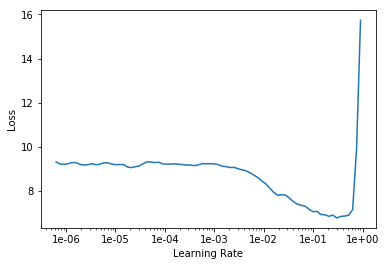

In [34]:
learner.recorder.plot(skip_end=1)

In [35]:
learner.fit_one_cycle(5, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.466214,0.417982,0.642091,00:39
1,0.358698,0.516845,0.710198,00:34
2,0.379973,0.360047,0.593039,00:33
3,0.307417,0.324461,0.564441,00:39
4,0.283508,0.319185,0.560184,00:33


In [36]:
learner.save('tmp1')

In [37]:
_=learner.load('tmp1')
learner.freeze_to(-2)

learner.fit_one_cycle(2, slice(1e-03/(2.6**4),1e-03), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.286906,0.322076,0.562487,00:37
1,0.267880,0.325651,0.566053,00:43


In [38]:
learner.save('tmp2')

# Predicting one single item

In [40]:
learner.load('tmp2');

In [41]:
val_df = train_df.loc[val_idxs].copy()

In [42]:
one_item = val_df.loc[9043]
one_item

category1                                                        Women
category2                                             Women's Handbags
category3                                                      Satchel
brand_name                                                Michael Kors
text                 Michael KORS purse. Michael Kors. Women Women'...
shipping                                                             0
item_condition_id                                                    2
price                                                          4.99043
Name: 9043, dtype: object

In [43]:
type(one_item)

pandas.core.series.Series

In [44]:
pred,raw_pred = predict_one_item(learner,one_item,tab_db,text_db)

In [45]:
pred,raw_pred

(tensor([4.9338]), tensor([4.9338]))

Note: for some reason, this result is slightly different from the prediction using learner.get_preds(). See more below.

End

# Extra: testing predict_one_item function

In [46]:
learner.load('tmp2');

In [47]:
val_pred = learner.get_preds()

In [48]:
val_pred

[tensor([[2.3479],
         [2.4195],
         [3.0596],
         ...,
         [3.6885],
         [2.5004],
         [3.5081]]),
 tensor([2.7726, 3.1355, 3.4012,  ..., 4.1897, 2.3979, 3.2189])]

In [49]:
# val_pred[1].sort(descending=True)[0][17]
# val_pred[1].sort(descending=True)[1][17]

tensor(4.9904)

tensor(198)

In [50]:
val_pred[0][198] #predict
val_pred[1][198] #actual

tensor([4.9219])

tensor(4.9904)

Find that record with price (label) 4.9904

In [53]:
# for i,(f,l) in enumerate(learner.data.valid_ds):
#     if abs(l.obj-4.9904) <=0.001:
#         print(f,l)
#         print(i)
#         print('-'*10)

learner.data.valid_ds[436]


((TabularLine category1 Women; category2 Women's Handbags; category3 Satchel; brand_name Michael Kors; shipping 0; item_condition_id 0.1024; ,
  Text xxbos xxmaj michael xxup kors purse . xxmaj michael xxmaj kors . xxmaj women xxmaj women 's xxmaj handbags xxmaj satchel . a gorgeous gray metallic colored bag . xxmaj can be used as a cross body , it does have the strap for it . xxmaj used a couple of times . a little scuff on the left bottom corner which is shown above . xxmaj and it looks like a scratch located on the back ( last photo ) but you can barely tell it 's there . xxmaj other than that in perfect condition ! xxmaj with wallet .),
 FloatItem 4.9904327)

In [55]:
# val_df.loc[np.abs(val_df.price-4.9904)<=0.01]
val_df.loc[9043]

category1                                                        Women
category2                                             Women's Handbags
category3                                                      Satchel
brand_name                                                Michael Kors
text                 Michael KORS purse. Michael Kors. Women Women'...
shipping                                                             0
item_condition_id                                                    2
price                                                          4.99043
Name: 9043, dtype: object

In [80]:
val_df.loc[9043,txt_cols].text

"Michael KORS purse. Michael Kors. Women Women's Handbags Satchel. A gorgeous gray metallic colored bag. Can be used as a cross body, it does have the strap for it. Used a couple of times. A little scuff on the left bottom corner which is shown above. And it looks like a scratch located on the back (last photo) but you can barely tell it's there. Other than that in perfect condition! With wallet."

Found it!

## Comparing transformation of that record between learn.data.valid_ds and databunch 's one_item

In [81]:
learner.data.valid_ds[436][0][0].data
tab_db.one_item(val_df.loc[9043])[0]

[tensor([ 10, 108, 436, 711,   1]), tensor([0.1024])]

[tensor([[ 10, 108, 436, 711,   1]], device='cuda:0'),
 tensor([[0.1024]], device='cuda:0')]

In [84]:
text_db.one_item(val_df.loc[9043,txt_cols])[0]
text_db.one_item(val_df.loc[9043,txt_cols])[0].shape

print('---')

learner.data.valid_ds[436][0][1]
learner.data.valid_ds[436][0][1].data[:30]
len(learner.data.valid_ds[436][0][1].data)

tensor([[   2,    5,  268,    6,  275,  344,    9,    5,  268,    5,  275,    9,
            5,   14,    5,   14,   26,    5,  212,    5, 1476,    9,   20,  567,
          313,  965,  830,  128,    9,    5,  104,   92,   58,   95,   20,  772,
          146,   10,   34,  318,   77,   17,  489,   19,   34,    9,    5,   58,
           20,  574,   28,  193,    9,   20,  221, 2622,   33,   17,  427,  332,
         1945,  450,   27,  423,  346,    9,    5,   13,   34,  592,   91,   20,
         1646, 6013,   33,   17,  168,   39,  395,  511,   36,   72,   37,  104,
          740, 1491,   34,   26,  295,    9,    5,   51,  335,  113,   22,  141,
           40,   15,    5,   25,  422,    9]], device='cuda:0')

torch.Size([1, 102])

---


Text xxbos xxmaj michael xxup kors purse . xxmaj michael xxmaj kors . xxmaj women xxmaj women 's xxmaj handbags xxmaj satchel . a gorgeous gray metallic colored bag . xxmaj can be used as a cross body , it does have the strap for it . xxmaj used a couple of times . a little scuff on the left bottom corner which is shown above . xxmaj and it looks like a scratch located on the back ( last photo ) but you can barely tell it 's there . xxmaj other than that in perfect condition ! xxmaj with wallet .

array([   2,    5,  268,    6,  275,  344,    9,    5,  268,    5,  275,    9,    5,   14,    5,   14,   26,    5,
        212,    5, 1476,    9,   20,  567,  313,  965,  830,  128,    9,    5])

102

## Wrap it up

In [56]:
val_df = train_df.loc[val_idxs].copy()

In [57]:
tab_oneitem=tab_db.one_item(val_df.loc[9043],detach=True,cpu=True)

In [58]:
text_oneitem=text_db.one_item(val_df.loc[9043,txt_cols],detach=True,cpu=True)

In [59]:
_batch = [( ([tab_oneitem[0][0][0],tab_oneitem[0][1][0]],text_oneitem[0][0]), tab_oneitem[1][0] )]

In [61]:
tabtext_onebatch = tabtext_collate( _batch )

In [62]:
tabtext_onebatch = to_device(tabtext_onebatch,defaults.device)

In [63]:
result = learner.pred_batch(batch = to_device(tabtext_onebatch,defaults.device))

In [64]:
result

tensor([[4.9338]])

In [65]:
raw_pred,x = grab_idx(result,0,batch_first=None),tabtext_onebatch[0]

In [66]:
raw_pred,x

(tensor([4.9338]),
 [[tensor([[ 10, 108, 436, 711,   1]], device='cuda:0'),
   tensor([[0.1024]], device='cuda:0')],
  tensor([[   2,    5,  268,    6,  275,  344,    9,    5,  268,    5,  275,    9,
              5,   14,    5,   14,   26,    5,  212,    5, 1476,    9,   20,  567,
            313,  965,  830,  128,    9,    5,  104,   92,   58,   95,   20,  772,
            146,   10,   34,  318,   77,   17,  489,   19,   34,    9,    5,   58,
             20,  574,   28,  193,    9,   20,  221, 2622,   33,   17,  427,  332,
           1945,  450,   27,  423,  346,    9,    5,   13,   34,  592,   91,   20,
           1646, 6013,   33,   17,  168,   39,  395,  511,   36,   72,   37,  104,
            740, 1491,   34,   26,  295,    9,    5,   51,  335,  113,   22,  141,
             40,   15,    5,   25,  422,    9]], device='cuda:0')])

In [67]:
learner.data.single_ds.y.analyze_pred(raw_pred)

tensor([4.9338])

In [70]:
raw_pred - val_pred[1][198] #actual

tensor([-0.0567])

Slight different here. Could be from the collate function or the sampler (SortSampler in validation set?)

In [68]:
tabtext_onebatch[0][0][1].shape

torch.Size([1, 1])

In [69]:
# raw prediction straight from the model
learner.model(tabtext_onebatch[0][0],tabtext_onebatch[0][1])

tensor([[4.9338]], device='cuda:0', grad_fn=<AddmmBackward>)